## Image superresolution


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
%cd /content/drive/MyDrive/Colab\ Notebooks/aml2024-students/MiniAssignments/ma13_modl

/content/drive/MyDrive/Colab Notebooks/aml2024-students/MiniAssignments/ma13_modl


In [5]:
import torch
import os
import numpy as np
import matplotlib.pyplot as plt

import torchvision.transforms as T
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms.functional import InterpolationMode
import math
import torch.nn.functional as F

import torch
from torch import nn
from torch import optim

from undersampling import *
from dataset import *
from nets import *

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [6]:
# Upsampling factor; vary this and evaluate performance
upSamplingFactor = 4

# if uploaded data locally
dataset = TrainDataset('BSDS200',upSamplingFactor)
train_samples = int(len(dataset)*0.75)
test_samples = len(dataset)-train_samples
train_set, test_set = torch.utils.data.random_split(dataset, [train_samples, test_samples])

trainloader = DataLoader(train_set,shuffle=True)
testloader = DataLoader(test_set,shuffle=True)

# Classical reconstructions

Here, we will show the reconstructions using classical methods, including bilinear interpolation and least-square solution

$$\mathbf x_{\rm LS} =  \arg \min_{\mathbf x} \|\mathbf A\mathbf x-\mathbf y\|^2 ---(2)$$

This problem is solved using conjugate gradient optimization, which gives $\mathbf x_{\rm LS} =  \left(\mathbf A^T \mathbf A + \lambda~ \mathbf I\right)^{-1}\left(\mathbf A^T\mathbf b\right)$, where $\lambda=0.01$.

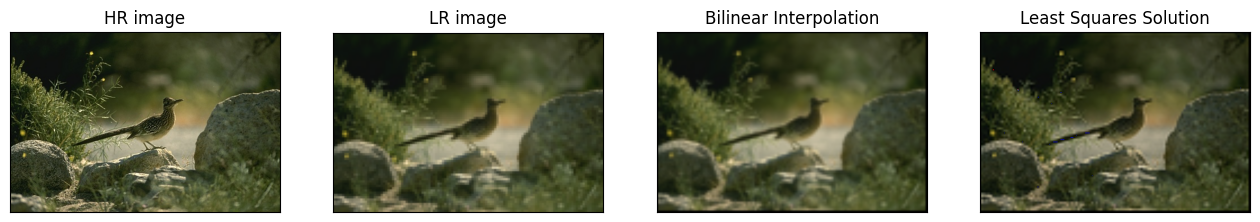

In [7]:
sigma = 0.0
hr_image = next(iter(trainloader))
A = underSamplingOperator(4)

testLR = A.forward(hr_image.cuda())
testLR = testLR+sigma*torch.randn(testLR.shape).cuda()
testHR = A.backward(testLR)
cg = cg_block(100,1e-2)
lhs = lambda x:A.normal(x)+0.01*x
out = cg(lhs,testHR,testHR).detach().cpu()
testHR = A.factor**2*A.backward(testLR)

fig, ax = plt.subplots(1,4,figsize=(16,4))
img = np.transpose(np.asarray(hr_image[0]),(1,2,0))
s=ax[0].imshow(np.uint8(255*img))
s=ax[0].set_title('HR image')
ax[0].get_xaxis().set_visible(False)
ax[0].get_yaxis().set_visible(False)

img = np.transpose(np.asarray(testLR[0].cpu()),(1,2,0))
s=ax[1].imshow(np.uint8(255*img))
s=ax[1].set_title('LR image')
ax[1].get_xaxis().set_visible(False)
ax[1].get_yaxis().set_visible(False)

img = np.transpose(np.asarray(testHR[0].cpu()),(1,2,0))
s=ax[2].imshow(np.uint8(255*img))
s=ax[2].set_title('Bilinear Interpolation')
s=ax[2].get_xaxis().set_visible(False)
s=ax[2].get_yaxis().set_visible(False)

img = np.transpose(np.asarray(out[0].cpu()),(1,2,0))
s=ax[3].imshow(np.uint8(255*img))
s=ax[3].set_title('Least Squares Solution')
ax[3].get_xaxis().set_visible(False)
ax[3].get_yaxis().set_visible(False)


## MoDL block

MoDL solves the optimization problem
$$\mathbf x^* = \arg \min_{\mathbf x} \|\mathbf A\mathbf x-\mathbf y\|^2 + \lambda \|\mathbf x-\mathcal D_{w}(\mathbf x)\|^2.$$
Here, $\mathcal D_{w}(\mathbf x)$ is a CNN denoiser.

The algorithm is solved using alternating minimization, which alternates between the following steps

$$\mathbf z_n = \mathcal D_{w}(\mathbf x_n)---(1)$$

$$\mathbf x_{n+1} =  \arg \min_{\mathbf x} \|\mathbf A\mathbf x-\mathbf y\|^2 + \lambda \|\mathbf x-\mathbf z_n\|^2---(2)$$
The above algorithm is unrolled for nUnroll steps. The output of the network is $\mathbf x_{nunroll}$, while its input is $\mathbf x_0$. It is a common practice to feed the least squares solution $\mathbf x_{0} =  \left(\mathbf A^T \mathbf A\right)^{-1}\left(\mathbf A^T\mathbf b\right)$ as the initialization.

Step (2) is implemented using a conjugate gradient algorithm with 5 iterations with an initialization of $\mathbf x_0=\mathbf x_n$, which solves

$$\mathbf x_{n+1} =  \left(\mathbf A^T \mathbf A + \lambda \mathbf I\right)^{-1}\left(\mathbf A^T\mathbf b + \lambda\mathbf z_n\right)$$

<font color=red> MODIFY THE FORWARD BLOCK OF THE MoDL CLASS </font>

In [9]:
class modl(nn.Module):

    def __init__(self, A,net,lam,nCGiter=5,tol=1e-4,nUnrolls=1)-> None:
        super(modl, self).__init__();

        # Feature extraction layer.
        self.A = A
        self.net = net
        self.lam = torch.tensor(lam,dtype=torch.float64).requires_grad_(True)
        self.cg = cg = cg_block(nCGiter,tol)
        self.nUnrolls = nUnrolls

    def forward(self, Atb:torch.Tensor,x0:torch.Tensor ) -> torch.Tensor:

        x = x0.clone()

        # YOUR CODE BELOW
        lhs = lambda x:A.normal(x) + self.lam * x

        for i in range(self.nUnrolls):
            z = Atb + self.lam * self.net(x)
            x = self.cg(lhs,z,x0=x)

        return x


0.09615264892578125 lam= 0.09991402973208803


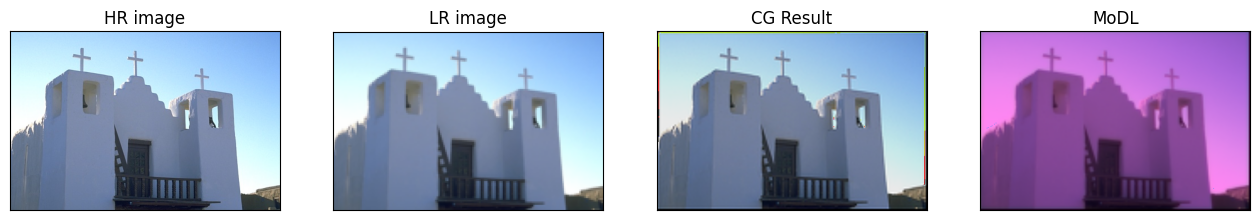

0.032645459175109866 lam= 0.09968209009781957


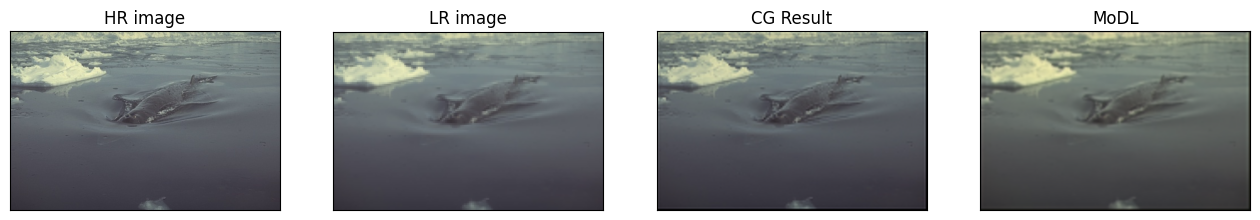

0.030498924255371093 lam= 0.09955987615608189


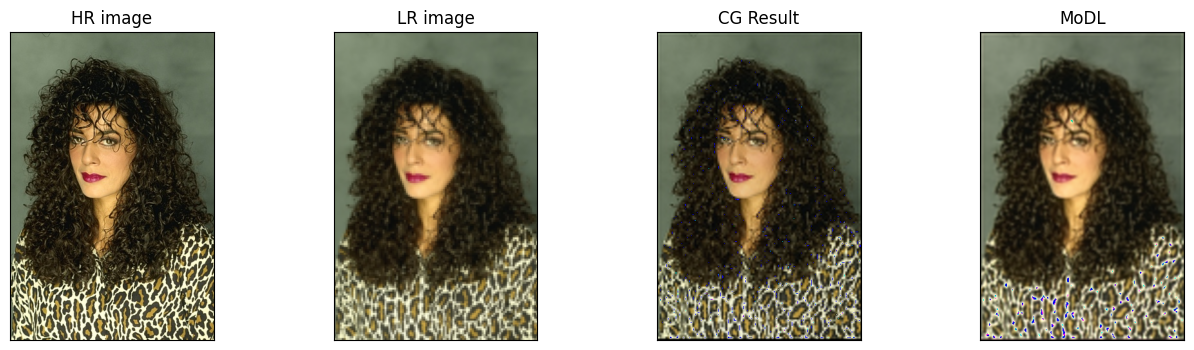

0.028298206329345703 lam= 0.09944948958037177


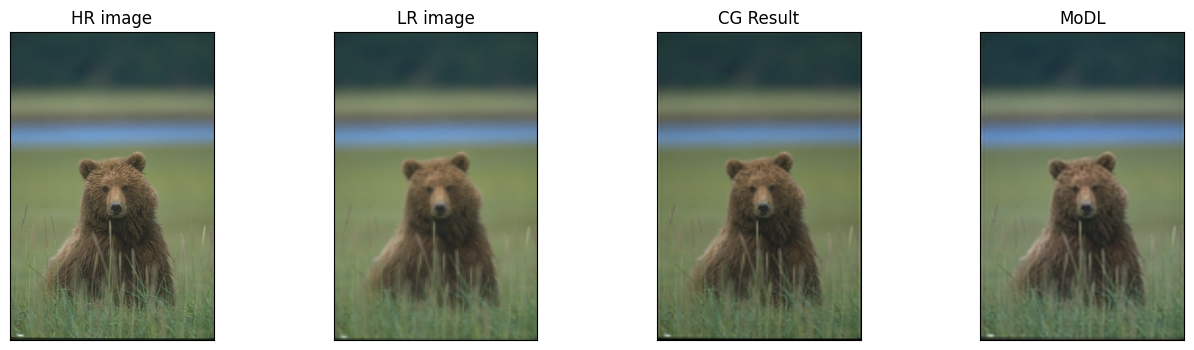

In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
A = underSamplingOperator(3)
net = SRCNN(32,upSamplingFactor=1).to(device)
maxUnrolls = 4
model = modl(A,net,0.1,nUnrolls=maxUnrolls)

lossfn = torch.nn.L1Loss(reduction='mean')

optimizer = optim.SGD([
                {'params': model.net.parameters(),'lr': 1e-3},
                {'params':model.lam,'lr': 1e-7}
            ], lr=1e-2, momentum=0.9)


for epoch in range(40): # shortened to save time
    epochloss = 0

    for hr_image in trainloader:
        x = int(hr_image.shape[2]/A.factor)*A.factor
        y = int(hr_image.shape[3]/A.factor)*A.factor
        hr_image = hr_image[:,:,:x,:y]

        testLR = A.forward(hr_image.cuda() )
        testLR = testLR+sigma*torch.randn(testLR.shape).cuda()
        testHR = A.backward(testLR)
        x0 = cg(lhs,testHR.cuda(),testHR.cuda()).detach().cpu()

        out = model(testHR.to(device),x0.to(device))

        cost =lossfn(out,hr_image.to(device))
        optimizer.zero_grad()
        cost.backward()
        optimizer.step()
        epochloss += cost
    if np.mod(epoch,10)==0:
        print(epochloss.item()/dataset.__len__(),'lam=',model.lam.item())

        fig, ax = plt.subplots(1,4,figsize=(16,4))
        img = np.transpose(np.asarray(hr_image[0]),(1,2,0))
        s=ax[0].imshow(np.uint8(255*img))
        s=ax[0].set_title('HR image')
        ax[0].get_xaxis().set_visible(False)
        ax[0].get_yaxis().set_visible(False)

        img = np.transpose(np.asarray(testLR[0].cpu()),(1,2,0))
        s=ax[1].imshow(np.uint8(255*img))
        s=ax[1].set_title('LR image')
        ax[1].get_xaxis().set_visible(False)
        ax[1].get_yaxis().set_visible(False)

        cgresult = cg(lhs,testHR,testHR).detach().cpu()
        img = np.transpose(np.asarray(cgresult[0]),(1,2,0))
        s=ax[2].imshow(np.uint8(255*img))
        s=ax[2].set_title('CG Result')
        s=ax[2].get_xaxis().set_visible(False)
        s=ax[2].get_yaxis().set_visible(False)

        img = np.transpose(np.asarray(out[0].detach().cpu()),(1,2,0))
        s=ax[3].imshow(np.uint8(255*img))
        s=ax[3].set_title('MoDL')
        ax[3].get_xaxis().set_visible(False)
        ax[3].get_yaxis().set_visible(False)
        #if(nUnrolls<maxUnrolls):
        #    nUnrolls = nUnrolls+1

        plt.show()



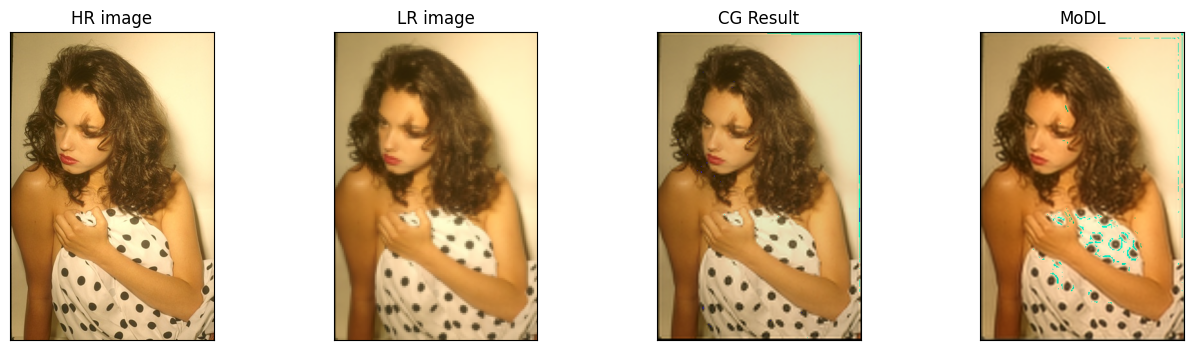

In [12]:
hr_image = next(iter(testloader))
x = int(hr_image.shape[2]/A.factor)*A.factor
y = int(hr_image.shape[3]/A.factor)*A.factor
hr_image = hr_image[:,:,:x,:y]

testLR = A.forward(hr_image.cuda() )
testLR = testLR+sigma*torch.randn(testLR.shape).cuda()
testHR = A.backward(testLR)
x0 = cg(lhs,testHR.cuda(),testHR.cuda()).detach().cpu()

out = model(testHR.to(device),x0.to(device)).detach().cpu()


fig, ax = plt.subplots(1,4,figsize=(16,4))
img = np.transpose(np.asarray(hr_image[0]),(1,2,0))
s=ax[0].imshow(np.uint8(255*img))
s=ax[0].set_title('HR image')
ax[0].get_xaxis().set_visible(False)
ax[0].get_yaxis().set_visible(False)

img = np.transpose(np.asarray(testLR[0].cpu()),(1,2,0))
s=ax[1].imshow(np.uint8(255*img))
s=ax[1].set_title('LR image')
ax[1].get_xaxis().set_visible(False)
ax[1].get_yaxis().set_visible(False)

cgresult = cg(lhs,testHR,testHR).detach().cpu()
img = np.transpose(np.asarray(cgresult[0]),(1,2,0))
s=ax[2].imshow(np.uint8(255*img))
s=ax[2].set_title('CG Result')
s=ax[2].get_xaxis().set_visible(False)
s=ax[2].get_yaxis().set_visible(False)

img = np.transpose(np.asarray(out[0].detach().cpu()),(1,2,0))
s=ax[3].imshow(np.uint8(255*img))
s=ax[3].set_title('MoDL')
ax[3].get_xaxis().set_visible(False)
ax[3].get_yaxis().set_visible(False)

plt.show()
